In [1]:
import pandas as pd

from rdkit import Chem, DataStructs
from rdkit.Chem import rdmolops, rdMolAlign
from rdkit.Chem import Draw, rdFMCS, AllChem, rdmolfiles, Descriptors, rdchem, rdMolDescriptors, rdmolops, rdFMCS
from rdkit.Chem.AtomPairs import Pairs
from rdkit.Chem import Draw

from rdkit.Chem.Draw import IPythonConsole

from IPython.display import display
from IPython.display import SVG,Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

In [2]:
perts_to_intrap = [
    ["tyk2", "ejm_54~ejm_31"], # start with a few easy FEPs.
    ["tyk2", "ejm_42~ejm_44"],
    ["tyk2", "ejm_44~ejm_31"],
    
    ["tyk2", "jmc_27~ejm_54"], # now try a few ring jumps.
    ["tyk2", "ejm_43~ejm_47"],
    ["tyk2", "ejm_49~ejm_45"],
    ["tnks2", "5p~5m"],
    ["tnks2", "1b~3a"],
    
    ["tnks2", "1a~8a"], # charge jumps probably out of scope.
    
    ["eg5", "CHEMBL1084678~CHEMBL1085666"], # some challenging multi-R-group ones.
    ["eg5", "CHEMBL1077227~CHEMBL1096002"], 
    ["eg5", "CHEMBL1082249~CHEMBL1085666"],
    
    ["galectin", "07_ligOH~05_ligOEt"], # tests a large MCS
    
    ["cats", "CatS_165~CatS_132"],  # also large MCS, but also large transform.
    ["cats", "CatS_29~CatS_141"], # mostly interested in seeing what happens to sulfoxide
    ["jnk1", "18635-1~18636-1"], # another MCS check. This transformation is already as 'small as can be'
    ["jnk1", "18627-1~18625-1"], # what if the transformation is already small as can be; but also just para->ortho?
    ["jnk1", "18634-1~18659-1"], # together with next; do both directions (A->B/B->A) result in same intermediate?
    ["jnk1", "18659-1~18634-1"]
                ]

In [3]:
def generateIntermediate(liga, ligb):
    """Placeholder function for generating a ligand intermediate between two ligand endpoints. Currently 
    just returns benzene. Replace with any intermediate generator code."""
    
    return Chem.MolFromSmiles("c1ccccc1")

In [4]:
def alignLigands(liga, intermediate, ligb):
    """Given a triplet of ligands; align to the first ligand such that we can more easily view differences.
    All ligand manipulations are done in-place."""
    # NB: when actual intermediates are being generated; include the intermediate in the MCS detection and
    # in the alignment!
    
    template = Chem.MolFromSmarts(rdFMCS.FindMCS([liga, intermediate, ligb],
                                    atomCompare=rdFMCS.AtomCompare.CompareAny,
                                    bondCompare=rdFMCS.BondCompare.CompareAny,
                                    matchValences=False,
                                    ringMatchesRingOnly=True,
                                    completeRingsOnly=True,
                                    matchChiralTag=False,
                                    timeout=2).smartsString) # need to set timeout because for some scaffolds the MCS
                                                             # can take minutes.
    AllChem.Compute2DCoords(template)
    
    for lig in [liga, intermediate, ligb]:
        # align.
        AllChem.GenerateDepictionMatching2DStructure(lig, template)
        # Remove stereochemistry to simplify depiction in network.
        rdmolops.RemoveStereochemistry(lig)
    
    return liga, intermediate, ligb

In [5]:
def getMolImg(mol):
    """Saves a molecule image and loads it back in and returns it. Allows viewing RDKit molecules during 
    loop iterations. """

    Draw.MolToFile(mol, "plt_workdir/tmp.png")
    img = mpimg.imread("plt_workdir/tmp.png")
    
    return img    

In [6]:
def depictMolTriplet(liga, intermediate, ligb, tgt, pert_name):
    """given three molecular inputs, plot a graph of each, side-by-side."""
    
    # get img objects for each lig
    img0 = getMolImg(liga)
    img1 = getMolImg(intermediate)
    img2 = getMolImg(ligb)

    # now plot.
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1, 1]})

    axes[0].imshow(img0)
    axes[1].imshow(img1)
    axes[2].imshow(img2)

    # turn off axes and set titles.
    titles = ["$\lambda = 0$", "Intermediate", "$\lambda = 1$"]
    for ax, title in zip(axes, titles):
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        ax.set_title(title)

    # annotate the left-hand side plot with the perturbation name instead of y axis label.
    axes[0].text(-0.05, 0.5*(0.25+0.75), f"{tgt.upper()}: {pert_name}",
        horizontalalignment='right',
        verticalalignment='center',
        rotation='vertical',
        transform=axes[0].transAxes)
    
    plt.show()

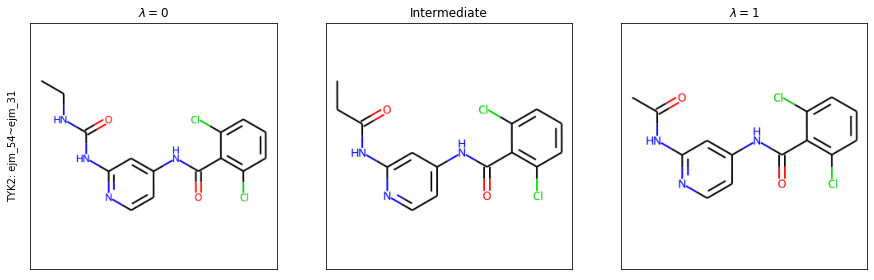

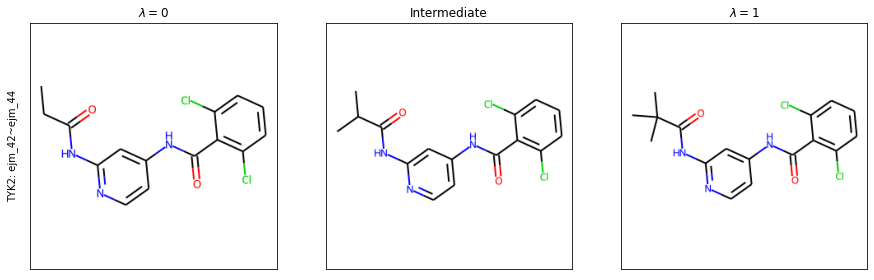

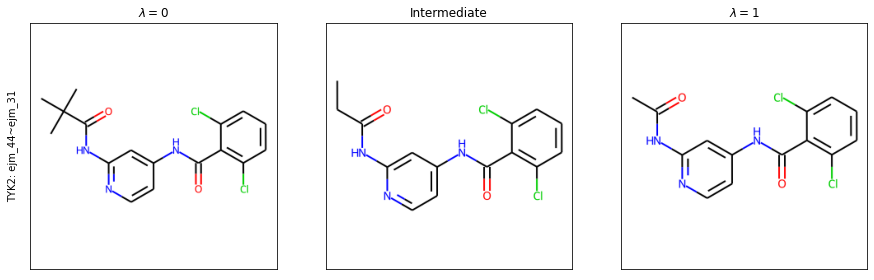

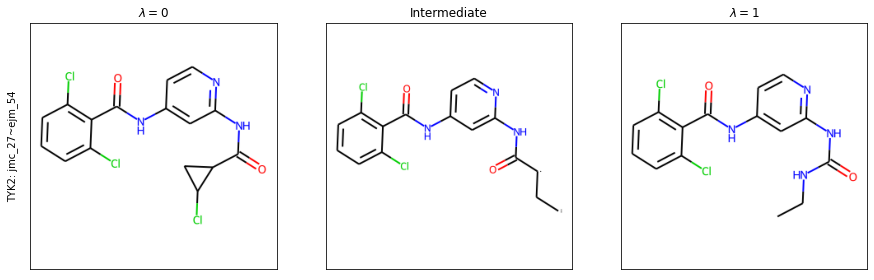

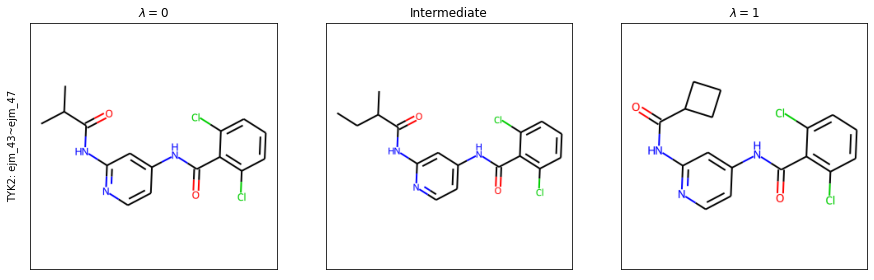

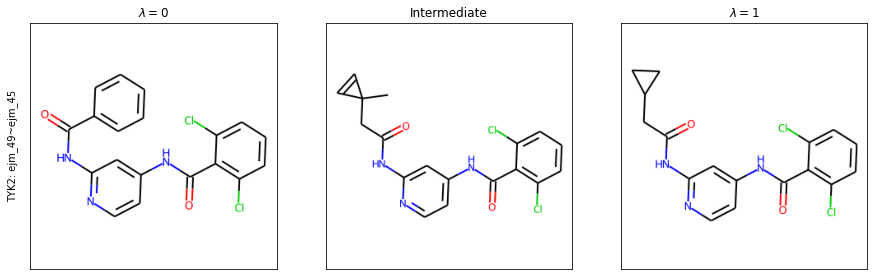

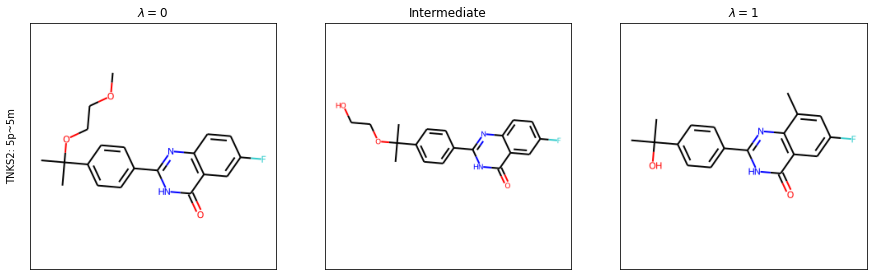

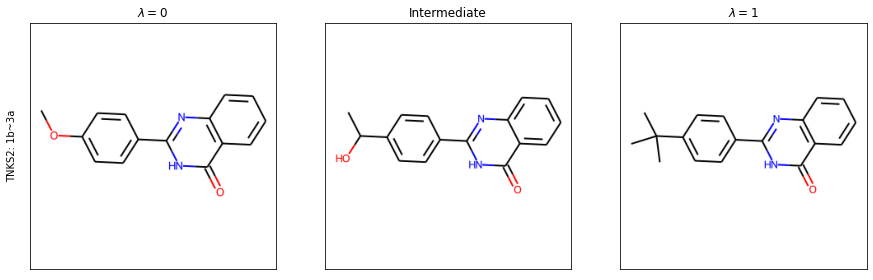

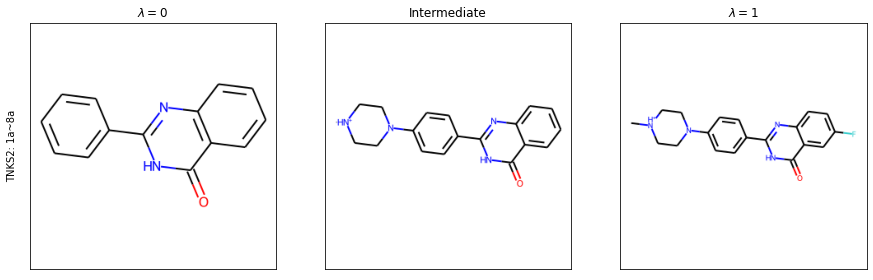

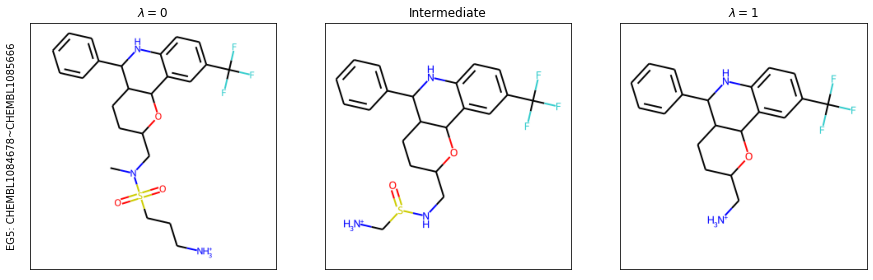

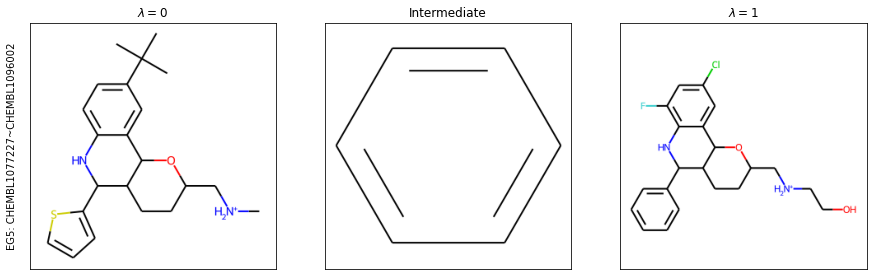

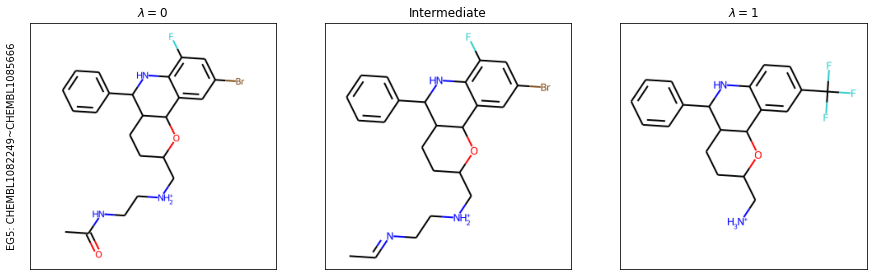

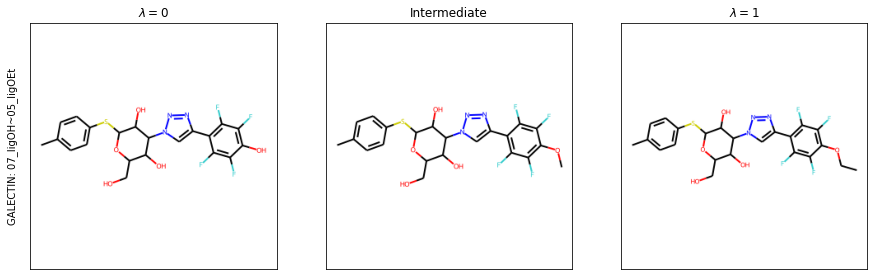

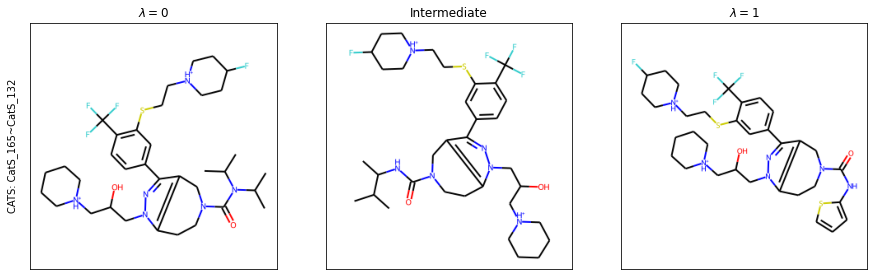

In [11]:
with open("test", "rb") as fp:   # Unpickling
    expert_intermediates = pickle.load(fp)

for (tgt, pert), interm in zip(perts_to_intrap, expert_intermediates):
    
    # get the endpoint molecular objects.
    liga, ligb = pert.split("~")
    try:
        liga, ligb = [ Chem.rdmolfiles.SDMolSupplier(f"ligands/{tgt}/{lig}.sdf")[0] for lig in [liga, ligb]]
    except OSError:
        # naming is inconsistent; try with 'lig_' prefix.
        liga, ligb = [ Chem.rdmolfiles.SDMolSupplier(f"ligands/{tgt}/lig_{lig}.sdf")[0] for lig in [liga, ligb]]
  
    # generate the intermediate.
    intermediate = Chem.MolFromSmiles(interm)
    
    # align everything. 
    liga, intermediate, ligb = alignLigands(liga, intermediate, ligb)
    
    # plot the triplet.
    depictMolTriplet(liga, intermediate, ligb, tgt, pert)